<a href="https://colab.research.google.com/github/marjansherafati/LSTMs-to-create-poetry/blob/master/Using_LSTMs_to_create_poetry_based_on_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate poetry from Shakespeare

The goal of this notebook is to build an NLP model using LSTMs, and see if we can generate new poetry similar to that of Shakespeare. I will use Keras to build and train the NLP model.


let's start with importing the libraries and APIs we need to use

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

# Data Preprocessing

Let's load the data (from Laurence Moroney's blog) and take this corpus to create training instances for the model.

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://raw.githubusercontent.com/marjansherafati/LSTMs-to-create-poetry/master/shakespeare.txt \
    -O /tmp/shakespeare.txt
data = open('/tmp/shakespeare.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	#generate token list for each line in the corpus
	token_list = tokenizer.texts_to_sequences([line])[0]
	#iterate over list of tokens to create n-gram sequences
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


#find the length of longest sentence. pad the rest of sequences to match max length 
max_sequence_len = max([len(x) for x in input_sequences])
#add padding, by doing a pre-pad
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label from input_sequences
#in each sequence, let's take the last element as the label and all before the last element as predictors
#basically, we are trying to classify what the next word would be, given all previous words
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]


#since this is a classification problem, we should convert the list of labels to create 1-hot encodings
label = ku.to_categorical(label, num_classes=total_words)

--2020-04-27 20:20:16--  https://raw.githubusercontent.com/marjansherafati/LSTMs-to-create-poetry/master/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95734 (93K) [text/plain]
Saving to: ‘/tmp/shakespeare.txt’

/tmp/shakespeare.tx 100%[===================>]  93.49K  --.-KB/s    in 0.02s   

2020-04-27 20:20:16 (4.24 MB/s) - ‘/tmp/shakespeare.txt’ saved [95734/95734]



# Building the Model


Now that our data is in the format that we want, the next step is to build the neural network model.  In the code section below, we will see how we can add layers to the model and set different parameters.


In [3]:
model = Sequential()
#we will start with an embedding layer
#the input length that this layer should expect is of size (max_len -1)
#because the took the last word as label, so we are left with max_len-1 as input
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
#next, let's add a bidirectional LSTM layer with 150 units. We use bidirectional because we want our LSTM to carry information both forwards and backwards
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
#let's add another LSTM layer with 100 units
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#the final layer should be a dense one, with total_words as the size. This is because we are interested in what the next word is, given the previous words, and we want the output to be a 1-hot encoding
model.add(Dense(total_words, activation='softmax'))
#since this is a classification task, we will use categorical cross entropy as the loss function
#adam optimizer works specially well for tasks of this type, so that is the optimizer that we use
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

# Fitting model on data

next we will fit the model we built on the input data we created from Shakespeare's poetry

In [4]:
#it will take a lot of epochs for this model to converge, given the input data. That's why I have set the epoch count very high
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 5s 10ms/step - loss: 6.9111 - accuracy: 0.0211
Epoch 2/100
484/484 [==============================] - 5s 10ms/step - loss: 6.5047 - accuracy: 0.0224
Epoch 3/100
484/484 [==============================] - 5s 10ms/step - loss: 6.3784 - accuracy: 0.0272
Epoch 4/100
484/484 [==============================] - 5s 10ms/step - loss: 6.2618 - accuracy: 0.0292
Epoch 5/100
484/484 [==============================] - 5s 10ms/step - loss: 6.1784 - accuracy: 0.0358
Epoch 6/100
484/484 [==============================] - 5s 10ms/step - loss: 6.0951 - accuracy: 0.0385
Epoch 7/100
484/484 [==============================] - 5s 10ms/step - loss: 6.0190 - accuracy: 0.0396
Epoch 8/100
484/484 [==============================] - 5s 10ms/step - loss: 5.9268 - accuracy: 0.0448
Epoch 9/100
484/484 [==============================] - 5s 10ms/step - loss: 5.8227 - accuracy: 0.0545
Epoch 10/100
484/484 [==============================] - 5s 10ms/step - loss: 5.714

# Analyzing the results

now that the model is trained ,let's look at how accuracy and loss change over every epoch.

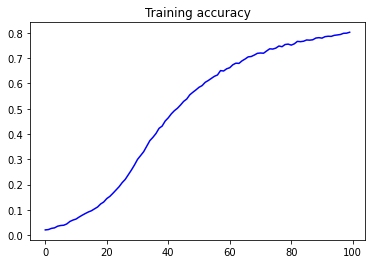

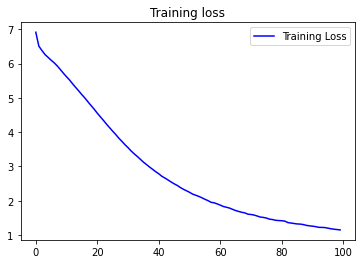

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

as expeced, model accuracy is increasing and loss is decreasing with every epoch

# Making New Poetry

now let's try to generate poetry!!

we will start the poem with a phrase and let the model compute the next most likey words.

I'm only creating 10 more words. We can increase the number of words that we want the model to generate, but should be aware that the more words we predict, the less certain the words will be, and the more they will end up as gibberish!

we can try the below poem creating exercise with any seed text and any number of words to follow! Enjoy!

In [10]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope or endless age rhyme end ' dyed new end torn
